In [773]:
#日付
import datetime
#平方根
from math import sqrt
#numpyのインストール
import numpy as np
#pandasのインストール
import pandas as pd
#statsmodelsのインストール
import statsmodels.api as sm
#時系列モデルのインストール
from statsmodels.tsa import stattools as st
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import coint as ct
#scikit-learnのインストール
import sklearn.linear_model as lm
#msnoのインストール
import missingno as msno
#pyplotのインストール
import matplotlib.pyplot as plt
#seabornのインストール
import seaborn as sns
%matplotlib inline
sns.set()
lr = lm.LinearRegression()

In [774]:
w_data = pd.read_csv('data4.csv', index_col='year', parse_dates=True)

In [775]:
w_data = w_data.loc[:'2015-12-01']

In [776]:
x_true_value = w_data.loc['2016-01-01':]

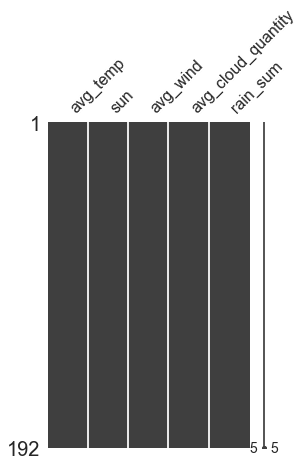

In [777]:
#データ欠損の確認 (欠損なし！)
msno.matrix(df=w_data,figsize=(4,6))

# ADF検定（単位根検定の資料）
## https://www.slideshare.net/teramonagi/r-7066155
## P-values > 0.05 then, 単位根
## wind, cloudが単位根、それ以外が定常性を持つ

In [778]:
#原系列に対するADF検定
print (st.adfuller(w_data['avg_temp'].values.ravel()))
print (st.adfuller(w_data['sun'].values.ravel()))
print (st.adfuller(w_data['avg_wind'].values.ravel()))
print (st.adfuller(w_data['rain_sum'].values.ravel()))
print (st.adfuller(w_data['avg_cloud_quantity'].values.ravel()))

(-3.2900637663836467, 0.015328508913554114, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 560.484979923089)
(-5.616589192480479, 1.170606324354971e-06, 5, 186, {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}, 1800.7981370591356)
(-1.9690874586506262, 0.3002894367029275, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 133.76320669439235)
(-7.969310934484765, 2.8091012202364616e-12, 9, 182, {'1%': -3.4668001583460613, '5%': -2.8775552336674317, '10%': -2.5753075498128246}, 2119.8995652066324)
(-2.8600582212346004, 0.05019373726663235, 12, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 498.0715668537154)


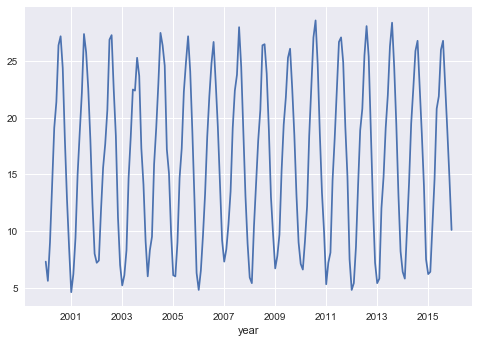

In [779]:
#原系列のplot
w_data['avg_temp'].plot()

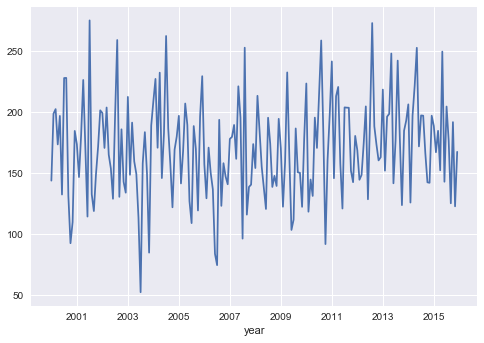

In [780]:
w_data['sun'].plot()

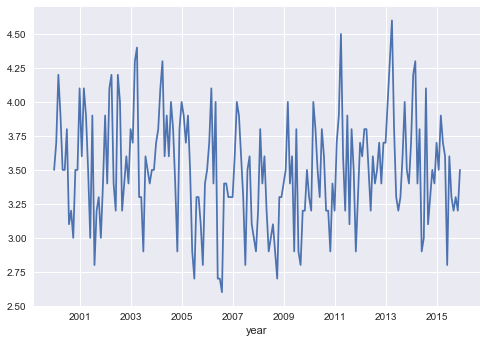

In [781]:
w_data['avg_wind'].plot()

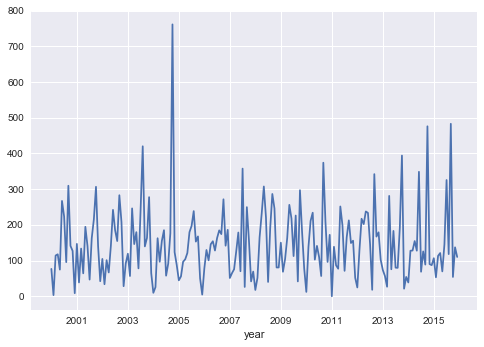

In [782]:
w_data['rain_sum'].plot()

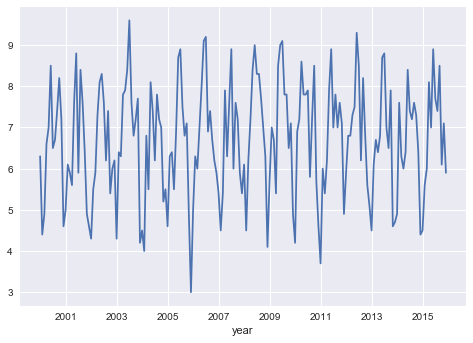

In [783]:
w_data['avg_cloud_quantity'].plot()

In [784]:
"""
##各移動平均と差分系列を取得
#気温
temp_data = w_data.loc[:,['avg_temp']]
temp_moving_avg = temp_data.rolling(window=12).mean().dropna()
temp_diff = temp_data.diff().dropna()
#日差し
sun_data = w_data.loc[:,['sun']]
sun_moving_avg = sun_data.rolling(window=12).mean().dropna()
sun_diff = sun_data.diff().dropna()
#雨量
rain_data = w_data.loc[:,['rain_sum']]
rain_moving_avg = rain_data.rolling(window=12).mean().dropna()
rain_diff = rain_data.diff().dropna()
"""
#風量
wind_data = w_data.loc[:,['avg_wind']]
wind_moving_avg = wind_data.rolling(window=12).mean().dropna()
wind_diff = wind_data.diff().dropna()
#雲量
cloud_data = w_data.loc[:,['avg_cloud_quantity']]
cloud_moving_avg = cloud_data.rolling(window=12).mean().dropna()
cloud_diff = cloud_data.diff().dropna()

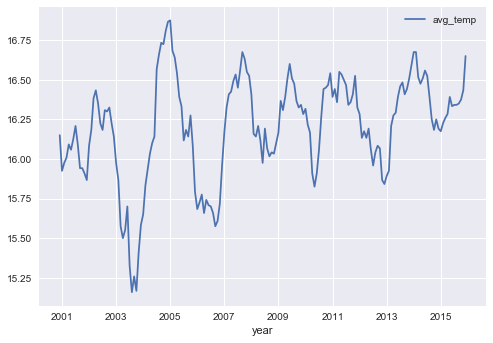

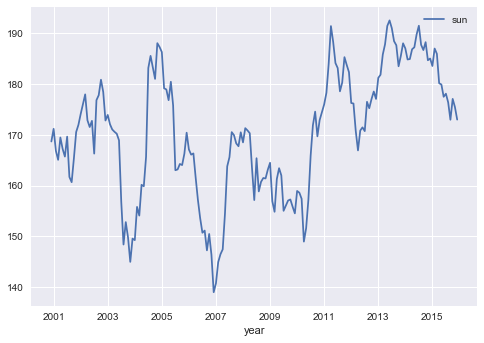

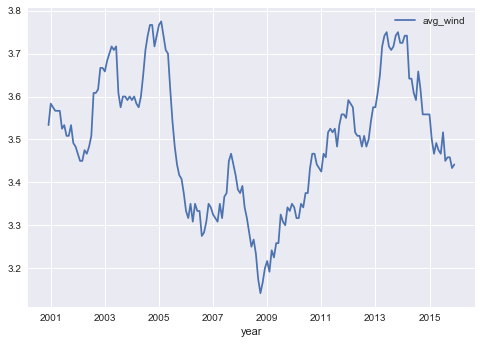

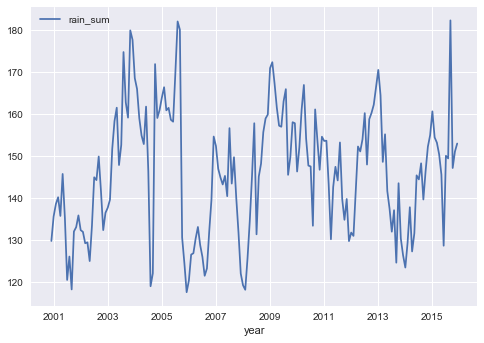

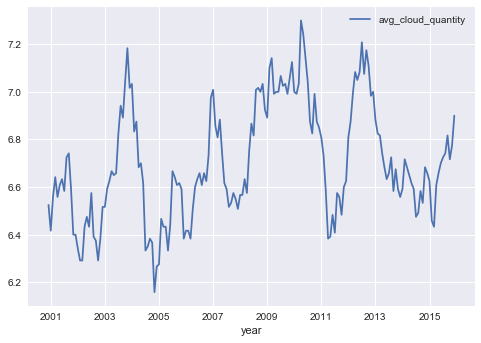

In [785]:
temp_moving_avg.plot()
sun_moving_avg.plot()
wind_moving_avg.plot()
rain_moving_avg.plot()
cloud_moving_avg.plot()

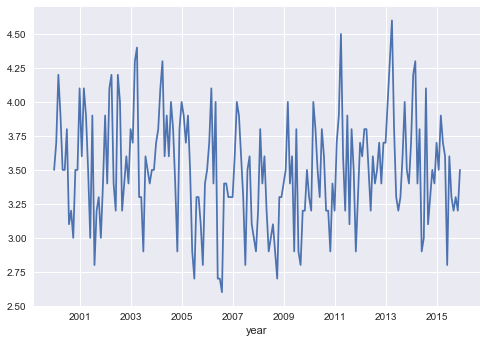

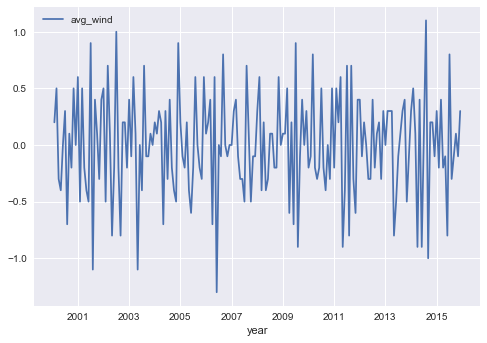

In [786]:
#差分系列のplot
#temp_diff.plot()
#sun_diff.plot()
w_data['avg_wind'].plot()
wind_diff.plot()
#rain_diff.plot()

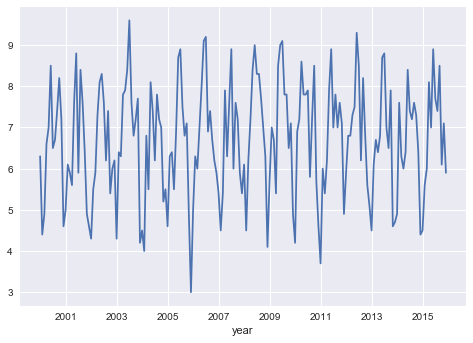

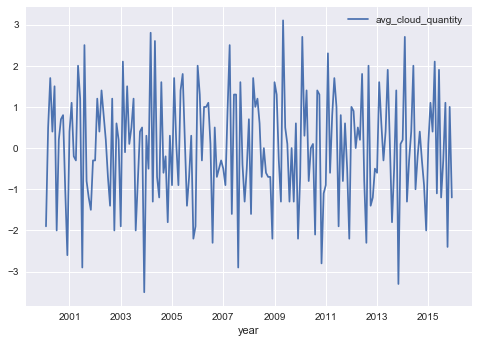

In [787]:
w_data['avg_cloud_quantity'].plot()
cloud_diff.plot()

In [788]:
#差分系列をADF検定
# https://logics-of-blue.com/time-series-regression/ むやみに差分系列を
#print (st.adfuller(temp_diff['avg_temp'].values.ravel()))
#print (st.adfuller(sun_diff['sun'].values.ravel()))
print (st.adfuller(wind_diff['avg_wind'].values.ravel()))
#print (st.adfuller(rain_diff['rain_sum'].values.ravel()))
print (st.adfuller(cloud_diff['avg_cloud_quantity'].values.ravel()))
# 差分をとることで雲量、風量共に単位根過程から定常過程へ移った。

(-12.10730820681971, 1.9554655283788218e-22, 10, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 135.59317233937634)
(-10.686799428742827, 3.814864619840895e-19, 11, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 502.1098189982017)


In [789]:
#原系列の気温、日照時間、雨量と、差分系列の風速、雲量のデータを連携
#差分をとった際に、時系列の最初のデータ（2000-01-01)はNaNになるので、1月のデータを落として2月から開始にする。
diff_data = pd.concat([w_data.loc[:,['avg_temp','sun','rain_sum']],wind_diff,cloud_diff],axis=1).loc['2000-02-01':]

In [790]:
diff_data.head()

,avg_temp,sun,rain_sum,avg_wind,avg_cloud_quantity
year,,,,,
2000-02-01,5.6,198.9,3.0,0.2,-1.9
2000-03-01,9.0,202.7,114.0,0.5,0.5
2000-04-01,14.0,173.7,117.5,-0.3,1.7
2000-05-01,19.1,197.1,74.5,-0.4,0.4
2000-06-01,21.4,132.6,267.0,0.0,1.5


# 差分をとることで単位根過程から、定常過程になった
# 原系列と差分系列で相関分析〜
# ほんとは変数同士で、共和分検定をした方がいい (理想的には、VECM) が説明変数同士の相関関係をみるのにそこまでできない。

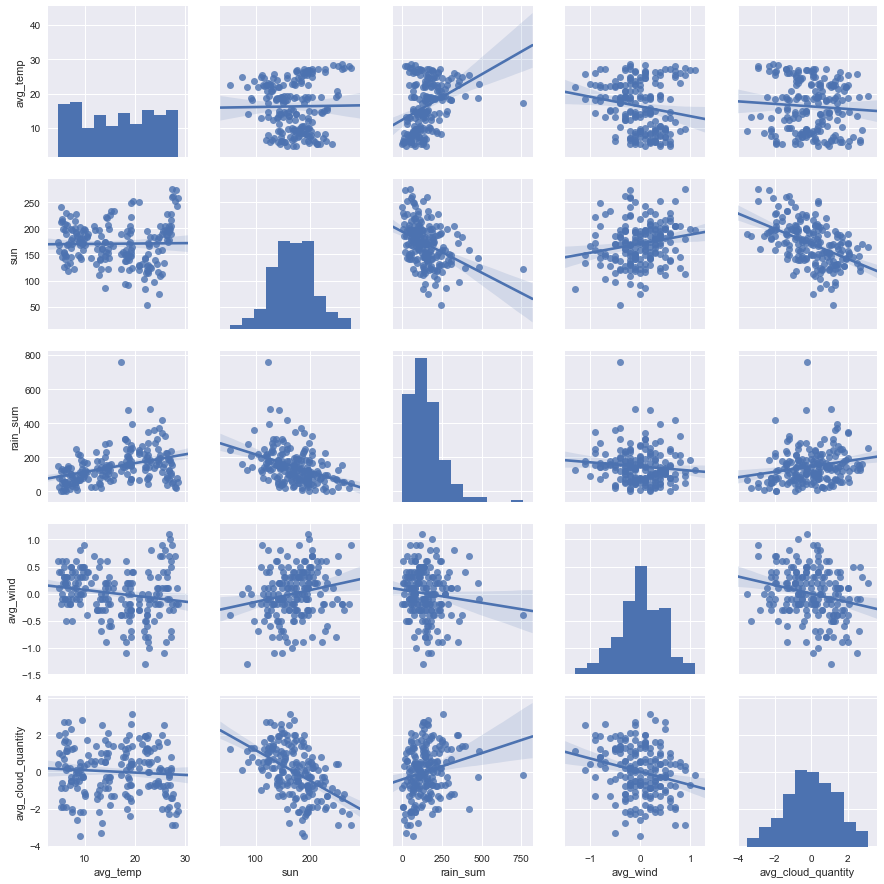

In [791]:
sns.pairplot(diff_data,kind='reg')

In [792]:
correlation_matrix = np.corrcoef(diff_data.transpose())

In [793]:
names = ['temperature','sunshine hours','wind spped','rainfall','cloud cover']

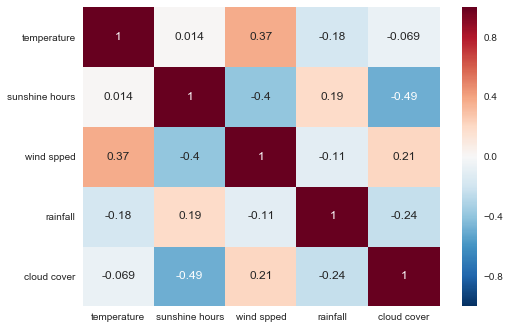

In [794]:
sns.heatmap(correlation_matrix, annot=True, xticklabels=names,yticklabels=names)

# Cloud quantityは日差しとか、気温とかとあまりにも相関するからバイバイする

In [795]:
w_data = w_data.drop(['avg_cloud_quantity'],axis=1)
diff_data = diff_data.drop(['avg_cloud_quantity'],axis=1)

# 横浜市のデータを読み込む！

# うまく書けなかった。。
num=2000
df = pd.DataFrame()

for i in range (15):
    df = df.append(pd.read_excel('yoko_econ.xlsx',sheetname=2016))
    num += 1

In [796]:
dat2000 = pd.read_excel('yoko_econ.xlsx',sheetname='2000').T.drop(['平均'],axis=0).reset_index()
dat2001 = pd.read_excel('yoko_econ.xlsx',sheetname='2001').T.drop(['平均'],axis=0).reset_index()
dat2002 = pd.read_excel('yoko_econ.xlsx',sheetname='2002').T.drop(['平均'],axis=0).reset_index()
dat2003 = pd.read_excel('yoko_econ.xlsx',sheetname='2003').T.drop(['平均'],axis=0).reset_index()
dat2004 = pd.read_excel('yoko_econ.xlsx',sheetname='2004').T.drop(['平均'],axis=0).reset_index()
dat2005 = pd.read_excel('yoko_econ.xlsx',sheetname='2005').T.drop(['平均'],axis=0).reset_index()
dat2006 = pd.read_excel('yoko_econ.xlsx',sheetname='2006').T.drop(['平均'],axis=0).reset_index()
dat2007 = pd.read_excel('yoko_econ.xlsx',sheetname='2007').T.drop(['平均'],axis=0).reset_index()
dat2008 = pd.read_excel('yoko_econ.xlsx',sheetname='2008').T.drop(['平均'],axis=0).reset_index()
dat2009 = pd.read_excel('yoko_econ.xlsx',sheetname='2009').T.drop(['平均'],axis=0).reset_index()
dat2010 = pd.read_excel('yoko_econ.xlsx',sheetname='2010').T.drop(['平均'],axis=0).reset_index()
dat2011 = pd.read_excel('yoko_econ.xlsx',sheetname='2011').T.drop(['平均'],axis=0).reset_index()
dat2012 = pd.read_excel('yoko_econ.xlsx',sheetname='2012').T.drop(['平均'],axis=0).reset_index()
dat2013 = pd.read_excel('yoko_econ.xlsx',sheetname='2013').T.drop(['平均'],axis=0).reset_index()
dat2014 = pd.read_excel('yoko_econ.xlsx',sheetname='2014').T.drop(['平均'],axis=0).reset_index()
dat2015 = pd.read_excel('yoko_econ.xlsx',sheetname='2015').T.drop(['平均'],axis=0).reset_index()
#dat2016は平均値をもたないよ（）
#http://www.city.yokohama.lg.jp/ex/stat/toukeisho/new/index3.html#12 データソース

/Users/Taishi/anaconda/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [797]:
#横浜市のデータを縦型に突合する
dat = pd.concat([dat2000,dat2001,dat2002,dat2003,dat2004,dat2005,dat2006,dat2007,dat2008,dat2009,dat2010,dat2011,dat2012,dat2013,dat2014,dat2015],axis=0)

In [973]:
tar_data = dat.set_index('index').loc[:,['消費支出','食料','住居','光熱・水道','家具・家事用品','被服及び履物','保健医療','交通・通信','教育','教養娯楽','その他の消費支出']]

In [799]:
#原系列に対するADF検定
print (st.adfuller(tar_data['消費支出'].values.ravel()))
print (st.adfuller(tar_data['食料'].values.ravel()))
print (st.adfuller(tar_data['住居'].values.ravel()))
print (st.adfuller(tar_data['光熱・水道'].values.ravel()))
print (st.adfuller(tar_data['家具・家事用品'].values.ravel()))
print (st.adfuller(tar_data['被服及び履物'].values.ravel()))
print (st.adfuller(tar_data['保健医療'].values.ravel()))
print (st.adfuller(tar_data['交通・通信'].values.ravel()))
print (st.adfuller(tar_data['教育'].values.ravel()))
print (st.adfuller(tar_data['教養娯楽'].values.ravel()))

(-1.8142038948570183, 0.3734330038095893, 11, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 4069.5035305453284)
(-2.8598647489026443, 0.050218207064792124, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 3074.4091909200088)
(-5.786426110743261, 4.987099498973615e-07, 2, 189, {'1%': -3.4654311561944873, '5%': -2.8769570530458792, '10%': -2.574988319755886}, 3669.275970009311)
(-4.0662669702101875, 0.0011006248966932929, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 3083.2184115307628)
(-5.024454015795098, 1.984843148415581e-05, 9, 374, {'1%': -3.4479562840494475, '5%': -2.869299109917524, '10%': -2.57090345105665}, 6703.186418351657)
(-3.5451502867737474, 0.006900487688402369, 11, 372, {'1%': -3.4480516066132636, '5%': -2.869340997473759, '10%': -2.5709257824604}, 6778.341365759103)
(-11.278548168300956, 1.4756880765410396e-20, 0, 191, {'1%': -3.465058702600837, 

In [800]:
##各移動平均と差分系列を取得
#消費
consumption_data = tar_data.loc[:,['消費支出']]
#consumption_moving_avg = consumption_data.rolling(window=12).mean().dropna()
consumption_diff = consumption_data.diff().dropna()
consumption_diff.columns = ['consumption']
"""
#食料
food_data = tar_data.loc[:,['食料']]
food_moving_avg = food_data.rolling(window=12).mean().dropna()
food_diff = food_data.diff().dropna()
#住居
estate_data = tar_data.loc[:,['住居']]
estate_moving_avg = estate_data.rolling(window=12).mean().dropna()
estate_diff = estate_data.diff().dropna()
#光熱、水道
utility_data = tar_data.loc[:,['光熱・水道']]
utility_moving_avg = utility_data.rolling(window=12).mean().dropna()
utility_diff = utility_data.diff().dropna()
#家具・家事用品
furniture_data = tar_data.loc[:,['家具・家事用品']]
furniture_moving_avg = furniture_data.rolling(window=12).mean().dropna()
furniture_diff = furniture_data.diff().dropna()
#被服及び履物
cloth_data = tar_data.loc[:,['被服及び履物']]
cloth_moving_avg = cloth_data.rolling(window=12).mean().dropna()
cloth_diff = cloth_data.diff().dropna()
#保健医療
medical_data = tar_data.loc[:,['保健医療']]
medical_moving_avg = medical_data.rolling(window=12).mean().dropna()
medical_diff = medical_data.diff().dropna()
#風量
com_data = tar_data.loc[:,['交通・通信']]
com_moving_avg = com_data.rolling(window=12).mean().dropna()
com_diff = com_data.diff().dropna()
#教育
edu_data = tar_data.loc[:,['教育']]
edu_moving_avg = edu_data.rolling(window=12).mean().dropna()
edu_diff = edu_data.diff().dropna()
#雲量
edu_fun_data = tar_data.loc[:,['教養娯楽']]
edu_fun_moving_avg = edu_fun_data.rolling(window=12).mean().dropna()
edu_fun_diff = edu_fun_data.diff().dropna()
"""

"\n#食料\nfood_data = tar_data.loc[:,['食料']]\nfood_moving_avg = food_data.rolling(window=12).mean().dropna()\nfood_diff = food_data.diff().dropna()\n#住居\nestate_data = tar_data.loc[:,['住居']]\nestate_moving_avg = estate_data.rolling(window=12).mean().dropna()\nestate_diff = estate_data.diff().dropna()\n#光熱、水道\nutility_data = tar_data.loc[:,['光熱・水道']]\nutility_moving_avg = utility_data.rolling(window=12).mean().dropna()\nutility_diff = utility_data.diff().dropna()\n#家具・家事用品\nfurniture_data = tar_data.loc[:,['家具・家事用品']]\nfurniture_moving_avg = furniture_data.rolling(window=12).mean().dropna()\nfurniture_diff = furniture_data.diff().dropna()\n#被服及び履物\ncloth_data = tar_data.loc[:,['被服及び履物']]\ncloth_moving_avg = cloth_data.rolling(window=12).mean().dropna()\ncloth_diff = cloth_data.diff().dropna()\n#保健医療\nmedical_data = tar_data.loc[:,['保健医療']]\nmedical_moving_avg = medical_data.rolling(window=12).mean().dropna()\nmedical_diff = medical_data.diff().dropna()\n#風量\ncom_data = tar_data.loc[:,['交通

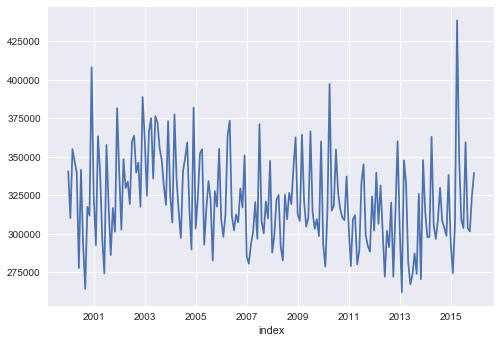

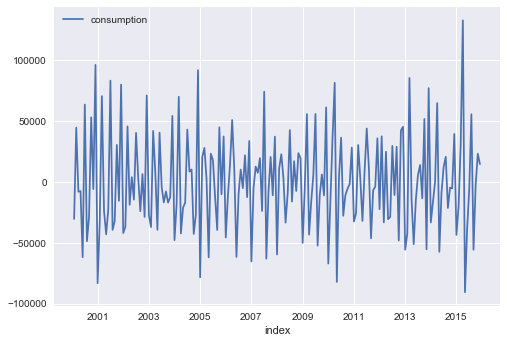

In [801]:
tar_data['消費支出'].plot()
consumption_diff.plot()

In [802]:
tar_data.head()

,消費支出,食料,住居,光熱・水道,家具・家事用品,家具・家事用品,被服及び履物,被服及び履物,保健医療,交通・通信,教育,教養娯楽,教養娯楽,その他の消費支出
index,,,,,,,,,,,,,,
2000-01-01,340685.0,7651.0,22575.0,27755.0,12681.0,796.0,20162.0,972.0,8759.0,34327.0,23925.0,28342.0,3884.0,86332.0
2000-02-01,310339.0,4922.0,24182.0,28342.0,9261.0,334.0,17196.0,877.0,10824.0,32836.0,12150.0,33440.0,1211.0,67899.0
2000-03-01,355097.0,5583.0,30488.0,24892.0,13904.0,678.0,20167.0,1701.0,11426.0,33520.0,26528.0,40628.0,1231.0,75429.0
2000-04-01,347138.0,5232.0,20862.0,22401.0,8417.0,131.0,15745.0,907.0,9137.0,33137.0,40804.0,48042.0,1705.0,71227.0
2000-05-01,339722.0,6903.0,21287.0,18980.0,6972.0,476.0,13528.0,1248.0,12310.0,48070.0,6864.0,64991.0,2766.0,68206.0


In [803]:
#差分系列に対するADF検定
"""
print (st.adfuller(tar_data['食料'].values.ravel()))
print (st.adfuller(tar_data['住居'].values.ravel()))
print (st.adfuller(tar_data['光熱・水道'].values.ravel()))
print (st.adfuller(tar_data['家具・家事用品'].values.ravel()))
print (st.adfuller(tar_data['被服及び履物'].values.ravel()))
print (st.adfuller(tar_data['保健医療'].values.ravel()))
print (st.adfuller(tar_data['交通・通信'].values.ravel()))
print (st.adfuller(tar_data['教育'].values.ravel()))
print (st.adfuller(tar_data['教養娯楽'].values.ravel()))
"""
st.adfuller(consumption_diff.values.ravel())
#pvalue < 0.05, 差分をとったことによる差分系列になった

(-8.00045229539132,
 2.3416464404906063e-12,
 10,
 180,
 {'1%': -3.4672111510631, '10%': -2.575403364197531, '5%': -2.877734766803841},
 4047.3788406504073)

In [804]:
tar_data.columns = [
    'consumption'
    ,'food'
    ,'estate'
    ,'utility'
    ,'furniture'
    ,'furniture_2'
    ,'cloth'
    ,'cloth_2'
    ,'medical'
    ,'telecom'
    ,'education'
    ,'edu_fun'
    ,'edu_fun_2'
    ,'else'
]

'\nfood_diff.plot()\nestate_diff.plot()\nutility_diff.plot()\nfurniture_diff.plot()\ncloth_diff.plot()\nmedical_diff.plot()\ncom_diff.plot()\nedu_diff.plot()\nedu_fun_diff.plot()\n'

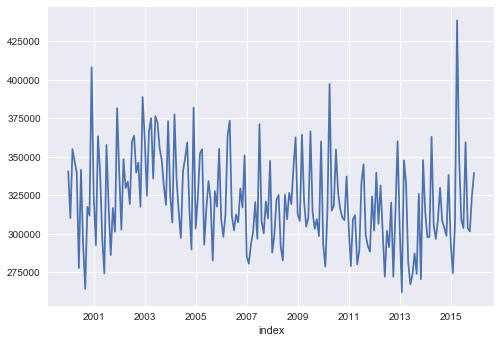

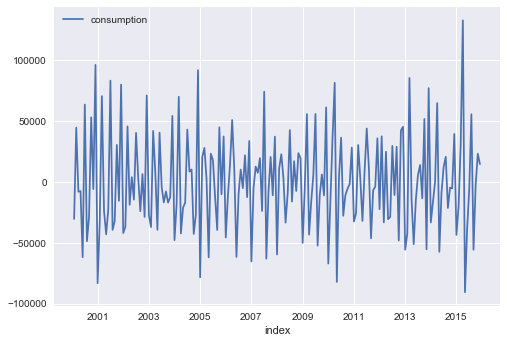

In [805]:
#差分
tar_data['consumption'].plot()
consumption_diff.plot()
"""
food_diff.plot()
estate_diff.plot()
utility_diff.plot()
furniture_diff.plot()
cloth_diff.plot()
medical_diff.plot()
com_diff.plot()
edu_diff.plot()
edu_fun_diff.plot()
"""

In [806]:
#diff_data_2 = pd.concat([consumption_diff,w_data.drop(['消費支出'],axis=1)],axis=1)

In [807]:
'''
diff_data_2.columns = [
    'consumption'
    ,'food'
    ,'estate'
    ,'utility'
    ,'furniture'
    ,'furniture_2'
    ,'cloth'
    ,'cloth_2'
    ,'medical'
    ,'telecom'
    ,'education'
    ,'edu_fun'
    ,'edu_fun_2'
]
'''

"\ndiff_data_2.columns = [\n    'consumption'\n    ,'food'\n    ,'estate'\n    ,'utility'\n    ,'furniture'\n    ,'furniture_2'\n    ,'cloth'\n    ,'cloth_2'\n    ,'medical'\n    ,'telecom'\n    ,'education'\n    ,'edu_fun'\n    ,'edu_fun_2'\n]\n"

In [810]:
diff_data.head()

,avg_temp,sun,rain_sum,avg_wind
year,,,,
2000-02-01,5.6,198.9,3.0,0.2
2000-03-01,9.0,202.7,114.0,0.5
2000-04-01,14.0,173.7,117.5,-0.3
2000-05-01,19.1,197.1,74.5,-0.4
2000-06-01,21.4,132.6,267.0,0.0


In [811]:
#x_train = 説明変数群
#y_train = 目的変数
x_train = diff_data
y_train = consumption_diff

# まずは、自己回帰や！
# https://logics-of-blue.com/time-series-forecast-by-machine-learning/ 参考

# まずはARモデル！！

In [812]:
#消費支出のみでの自己相関
ts_acf = st.acf(y_train,nlags=40)
print (ts_acf)

[ 1.         -0.3780117  -0.25390004  0.03277107  0.22950429 -0.02290466
 -0.23781948  0.06674476  0.10385042  0.13280119 -0.23435538 -0.19677877
  0.45945653 -0.10550038 -0.21517809  0.05845617  0.14740541  0.04133664
 -0.22747373 -0.00472768  0.19665222  0.06548124 -0.18082151 -0.22573833
  0.43050819 -0.11362272 -0.14837514 -0.00877914  0.12995693  0.12214752
 -0.27948631  0.03829691  0.10730501  0.14927712 -0.26689704 -0.05971039
  0.32151098 -0.15705281 -0.07782269 -0.01113084  0.13267684]


In [813]:
#消費支出のみでの偏自己相関
par_ts_acf_2 = st.pacf(y_train.values.ravel(),nlags=40)
print (par_ts_acf_2)

[ 1.00000000e+00 -3.80001234e-01 -4.68663154e-01 -4.31347375e-01
 -1.58634278e-01 -7.18445556e-03 -1.84688714e-01 -1.97001823e-01
 -2.33773750e-01  8.59405187e-02  2.74619471e-02 -4.16355114e-01
  4.13931548e-03 -6.22121005e-02 -1.68529803e-01  3.26157741e-04
 -9.55304719e-02  7.29522624e-02  1.51865908e-02 -1.82006910e-01
  1.14367432e-01  1.42449180e-01  1.83315251e-01 -8.69063113e-02
  8.25582771e-02 -1.43184361e-02  3.21016073e-02 -1.22070742e-02
 -1.15464838e-01  7.08293945e-02 -1.54575325e-01 -8.42568758e-02
 -9.14169906e-02  2.23592911e-02 -1.87765325e-01 -1.16186116e-01
  5.12184956e-02 -2.13903586e-01 -8.60752480e-02 -1.09818532e-01
 -4.58058614e-02]


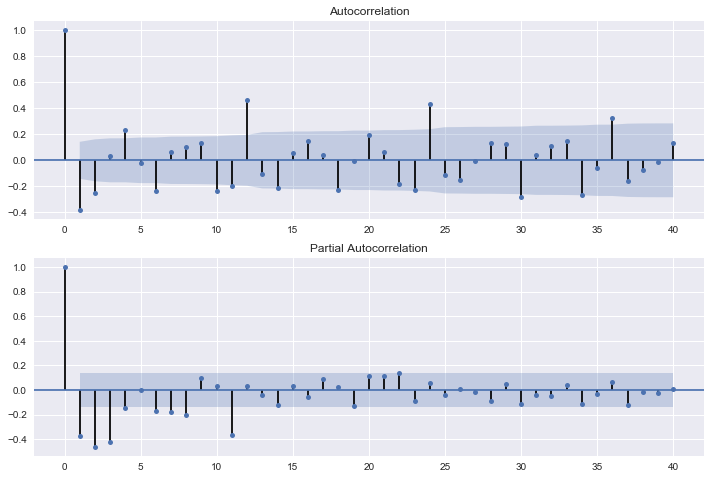

In [814]:
# 自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_train.values.ravel(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_train.values.ravel(), lags=40, ax=ax2)

# autocorrelation の方で、12期つまり1年毎の周期が観測されているよね

# ARMAモデルやるよ！！

In [815]:
#ARMAの次数推定
sm.tsa.arma_order_select_ic(y_train, ic='aic', trend='nc')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


{'aic':              0            1            2
 0          NaN  4477.689554  4479.572715
 1  4561.552176  4479.633540  4479.286147
 2  4517.503367  4469.644548  4471.626066
 3  4482.139335  4471.595376  4472.645620
 4  4480.103356  4467.398990  4469.389970, 'aic_min_order': (4, 1)}

In [819]:
arma = ARMA(tar_data['consumption'],order = [4,1,1]).fit(dist=False)
print (arma.params)

const                321694.161490
ar.L1.consumption         0.235643
ar.L2.consumption        -0.105735
ar.L3.consumption         0.152130
ar.L4.consumption         0.263385
ma.L1.consumption        -0.134712
dtype: float64


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


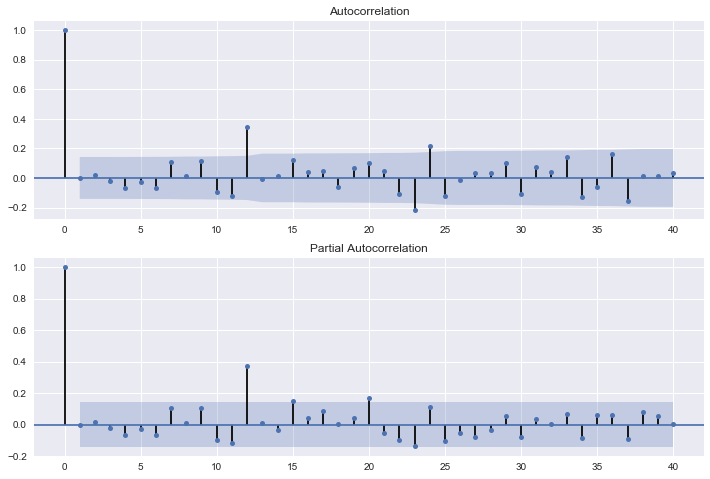

In [820]:
#残差の周期性を確認する
arma_resid = arma.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_resid, lags=40, ax=ax2)

# 周期残ってそう

In [821]:
#summary
arma.summary()

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            consumption   No. Observations:                  192
Model:                     ARMA(4, 1)   Log Likelihood               -2238.356
Method:                       css-mle   S.D. of innovations          27942.171
Date:                Mon, 22 Jan 2018   AIC                           4490.712
Time:                        02:00:32   BIC                           4513.514
Sample:                    01-01-2000   HQIC                          4499.947
                         - 12-01-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.217e+05   3776.026     85.194      0.000    3.14e+05    3.29e+05
ar.L1.consumption     0.2356      0.218      1.079      0.282      -0.192       0.664
ar.L2.consumption    -0.1057      0.079     -1.345      0.180      -0.260       0.048
ar.L3.consumption     0.1521      0.075      2.022      0.045       0.005       0.300
ar.L4.consumption     0.2634      0.083      3.162      0.002       0.100       0.427
ma.L1.consumption    -0.1347      0.224     -0.600      0.549      -0.575       0.305
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2239           -0.0000j            1.2239           -0.0000
AR.2           -0.0149           -1.3231j            1.3232           -0.2518
AR.3           -0.0149           +1.3231j            1.3232            0.2518
AR.4           -1.7718           -0.0000j            1.7718           -0.5000
MA.1            7.4232           +0.0000j            7.4232            0.0000
-----------------------------------------------------------------------------
"""

In [822]:
arma_pred = arma.predict('2015-12-01','2016-12-01')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


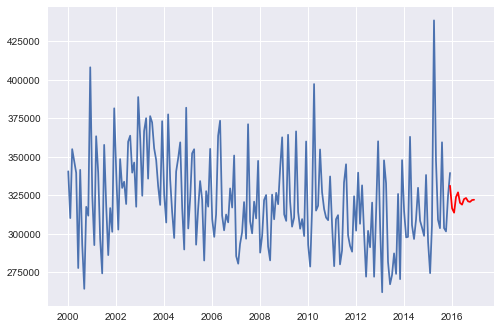

In [825]:
plt.plot(tar_data['consumption'])
plt.plot(arma_pred, "r")

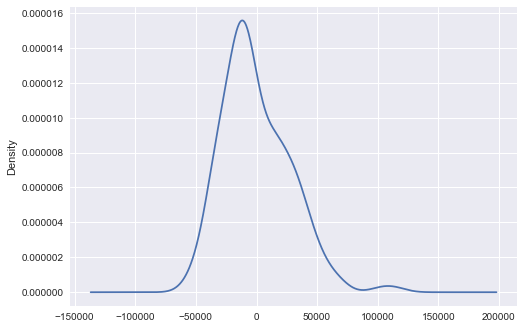

In [826]:
arma_resid.plot(kind='kde')

# そのまま ARIMAもやるよ!!

In [827]:
arimadayo = ARIMA(tar_data['consumption'],order = [4,1,1]).fit(dist=False)
print (arimadayo.params)

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


const                 -137.016297
ar.L1.D.consumption      0.081099
ar.L2.D.consumption     -0.118261
ar.L3.D.consumption      0.106270
ar.L4.D.consumption      0.256129
ma.L1.D.consumption     -1.000000
dtype: float64


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


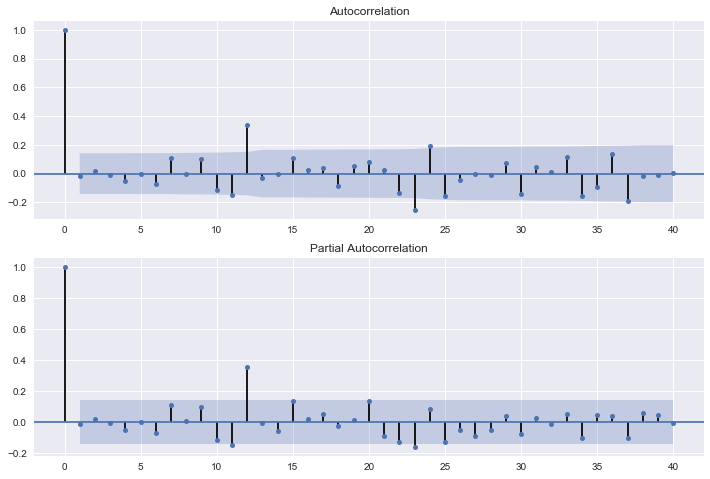

In [828]:
arima_resid = arimadayo.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_resid, lags=40, ax=ax2)

In [829]:
arimadayo.summary()

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.consumption   No. Observations:                  191
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2226.737
Method:                       css-mle   S.D. of innovations          27629.268
Date:                Mon, 22 Jan 2018   AIC                           4467.474
Time:                        02:00:54   BIC                           4490.240
Sample:                    02-01-2000   HQIC                          4476.695
                         - 12-01-2015                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -137.0163     51.906     -2.640      0.009    -238.751     -35.282
ar.L1.D.consumption     0.0811      0.070      1.153      0.251      -0.057       0.219
ar.L2.D.consumption    -0.1183      0.070     -1.691      0.093      -0.255       0.019
ar.L3.D.consumption     0.1063      0.070      1.517      0.131      -0.031       0.244
ar.L4.D.consumption     0.2561      0.070      3.658      0.000       0.119       0.393
ma.L1.D.consumption    -1.0000      0.017    -59.037      0.000      -1.033      -0.967
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3478           -0.0000j            1.3478           -0.0000
AR.2           -0.0511           -1.3198j            1.3208           -0.2562
AR.3           -0.0511           +1.3198j            1.3208            0.2562
AR.4           -1.6605           -0.0000j            1.6605           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [830]:
arima_pred = arimadayo.predict('2015-12-01','2016-12-01')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


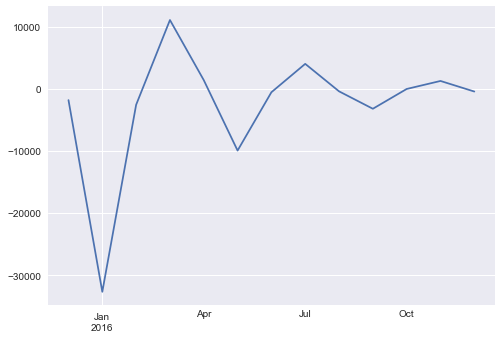

In [831]:
arima_pred.plot()

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


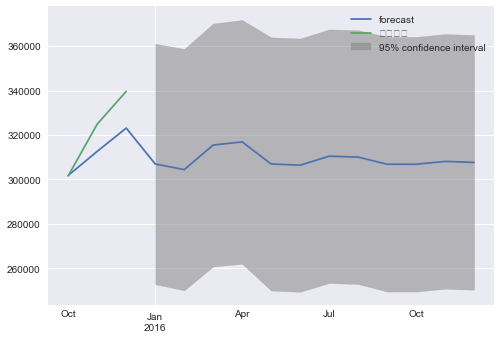

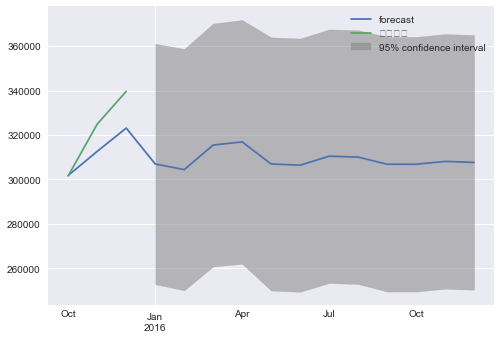

In [832]:
arima.plot_predict('2015-10-01','2016-12-01')

In [833]:
arima_pred.head()

2015-12-01    -1810.883924
2016-01-01   -32660.984473
2016-02-01    -2565.950143
2016-03-01    11082.510337
2016-04-01     1406.559968
Freq: MS, dtype: float64

In [835]:
hoge = tar_data.loc['2015-11-01':'2015-12-01',['consumption']]

In [836]:
hoge

,consumption
index,
2015-11-01,324938.0
2015-12-01,339648.0


In [837]:
hoge.columns = ['conp']

In [838]:
arima_pred_value = pd.concat([hoge,pd.DataFrame(arima_pred)],axis=0)

In [839]:
arima_pred_value.iloc[2,[1]]

0   -1810.883924
Name: 2015-12-01 00:00:00, dtype: float64

In [840]:
sample = pd.DataFrame(columns=['hoge'])

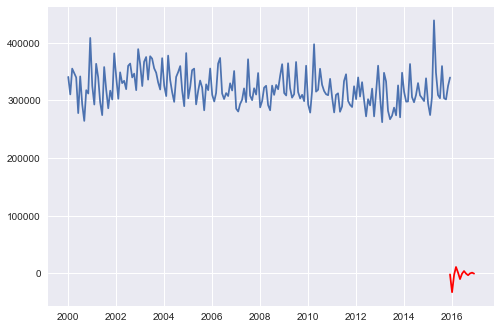

In [843]:
plt.plot(tar_data['consumption'])
plt.plot(arima_pred, "r")
plt.show()

In [844]:
arima_pred = [
    359409.8684,
    361975.8185,
    350893.3082,
    349486.7482,
    359413.8678,
    359957.2217,
    355931.7212,
    356328.145,
    359529.1734,
    359545.7255
]

In [845]:
year = [
   '2016/1/1',
   '2016/2/1',
    '2016/3/1',
    '2016/4/1',
    '2016/5/1',
    '2016/6/1',
    '2016/7/1',
    '2016/8/1',
    '2016/9/1',
    '2016/10/1'
]

In [846]:
year = pd.to_datetime(year,format='%Y-%m-%d')

In [847]:
arima_pred = pd.Series(arima_pred)
year = pd.Series(year)

In [848]:
arima_pred = pd.concat([arima_pred, year],axis=1)

In [849]:
arima_pred = arima_pred.set_index(1)

In [850]:
arima_pred

,0
1,
2016-01-01,359409.8684
2016-02-01,361975.8185
2016-03-01,350893.3082
2016-04-01,349486.7482
2016-05-01,359413.8678
2016-06-01,359957.2217
2016-07-01,355931.7212
2016-08-01,356328.1450
2016-09-01,359529.1734


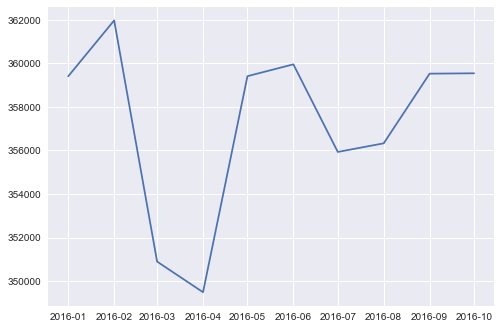

In [851]:
plt.plot(arima_pred)

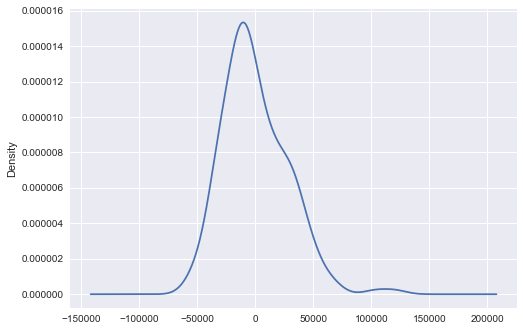

In [852]:
arima_resid.plot(kind='kde')

# SARIMAXをつかうんじゃー！

In [853]:
y_train.head()

,consumption
index,
2000-02-01,-30346.0
2000-03-01,44758.0
2000-04-01,-7959.0
2000-05-01,-7416.0
2000-06-01,-61825.0


In [854]:
sarimax = SARIMAX(tar_data['消費支出'], order=(2,0,4), enforce_stationarity=True, seasonal_order=(1,1,1,12)).fit(dist=False)

KeyError: '消費支出'

In [855]:
max_p = 4
max_q = 4
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
pattern

320

In [856]:
modelSelection.head()

,model,aic
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [857]:
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            y_train, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,4), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1

# モデルごとの結果確認
print(modelSelection)

# AIC最小モデル
print(modelSelection[modelSelection.aic == min(modelSelection.aic)])

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed

                             model      aic
0    order=(1,0,0), season=(0,0,0)  4537.95
1    order=(1,0,0), season=(0,0,1)   4428.7
2    order=(1,0,0), season=(0,1,0)  4499.86
3    order=(1,0,0), season=(0,1,1)  4313.76
4    order=(1,0,0), season=(1,0,0)  4425.84
5    order=(1,0,0), season=(1,0,1)  4389.45
6    order=(1,0,0), season=(1,1,0)  4363.26
7    order=(1,0,0), season=(1,1,1)  4315.23
8    order=(1,0,1), season=(0,0,0)  4432.37
9    order=(1,0,1), season=(0,0,1)  4331.54
10   order=(1,0,1), season=(0,1,0)  4424.53
11   order=(1,0,1), season=(0,1,1)  4273.46
12   order=(1,0,1), season=(1,0,0)  4353.91
13   order=(1,0,1), season=(1,0,1)  4325.07
14   order=(1,0,1), season=(1,1,0)  4326.27
15   order=(1,0,1), season=(1,1,1)  4273.98
16   order=(1,0,2), season=(0,0,0)  4408.76
17   order=(1,0,2), season=(0,0,1)  4305.76
18   order=(1,0,2), season=(0,1,0)  4374.63
19   order=(1,0,2), season=(0,1,1)  4221.93
20   order=(1,0,2), season=(1,0,0)  4351.89
21   order=(1,0,2), season=(1,0,

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


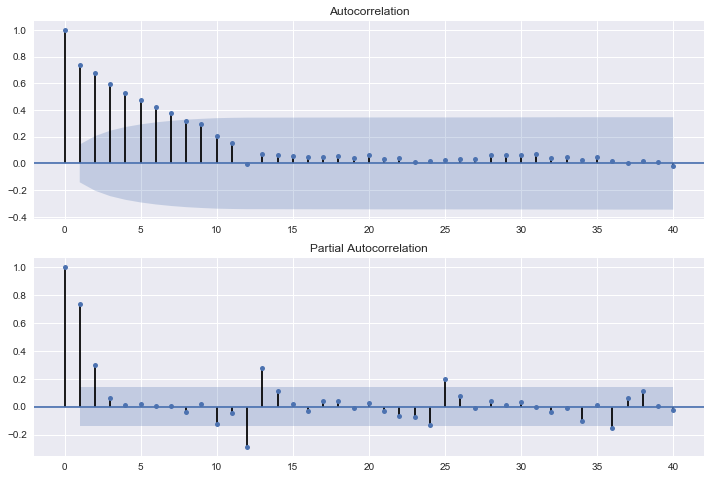

In [858]:
sarima_resid = sarimax.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_resid, lags=40, ax=ax2)

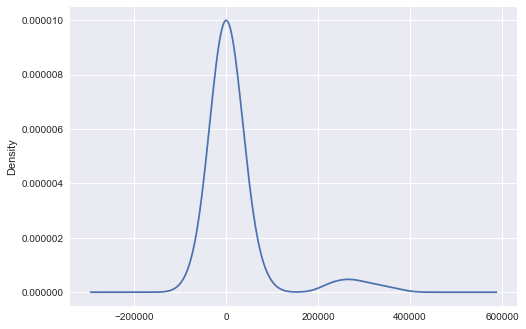

In [859]:
sarima_resid.plot(kind='kde')

# 周期性消えてそう

In [860]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               消費支出   No. Observations:                  192
Model:             SARIMAX(2, 0, 4)x(1, 1, 1, 12)   Log Likelihood               -2099.403
Date:                            Mon, 22 Jan 2018   AIC                           4216.805
Time:                                    02:03:23   BIC                           4246.123
Sample:                                01-01-2000   HQIC                          4228.679
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4177      0.569     -0.735      0.463      -1.532       0.697
ar.L2         -0.2193      0.485     -0.452      0.651      -1.169       0.731
ma.L1          0.5480      0.569      0.964      0.335      -0.567       1.663
ma.L2          0.2777      0.538      0.516      0.606      -0.777       1.333
ma.L3          0.0153      0.121      0.127      0.899      -0.222       0.253
ma.L4          0.1169      0.076      1.537      0.124      -0.032       0.266
ar.S.L12      -0.2867      0.353     -0.812      0.417      -0.979       0.406
ma.S.L12       0.1957      0.361      0.543      0.587      -0.511       0.903
sigma2      8.368e+08   1.66e-09   5.03e+17      0.000    8.37e+08    8.37e+08
===================================================================================
Ljung-Box (Q):                       63.83   Jarque-Bera (JB):                 1.32
Prob(Q):                              0.01   Prob(JB):                         0.52
Heteroskedasticity (H):               1.23   Skew:                             0.09
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.59e+33. Standard errors may be unstable.
"""

In [861]:
sarimax_pred = sarimax.predict('2015-12-01','2016-12-01')

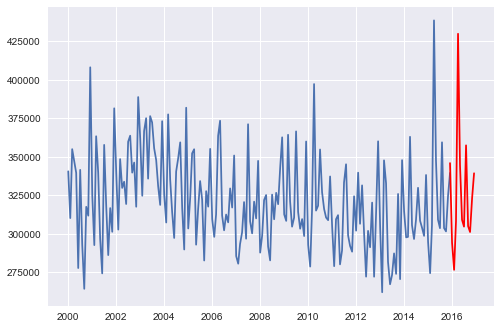

In [863]:
plt.plot(tar_data['consumption'])
plt.plot(sarimax_pred, "r")

In [864]:
#予測データデータフレームの形成
y_arma_pred = pd.DataFrame(arma_pred).loc['2016-01-01':'2016-10-01']
y_arima_pred = pd.DataFrame(arima_pred).loc['2016-01-01':'2016-10-01']
y_sarimax_pred = pd.DataFrame(sarimax_pred).loc['2016-01-01':'2016-10-01']

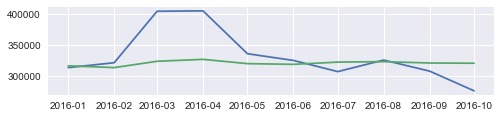

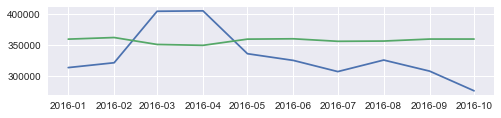

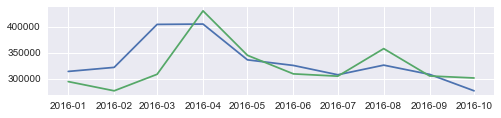

In [865]:
plt.subplot(3, 1,1)
plt.plot(y_test)
plt.plot(y_arma_pred)
plt.show()
plt.subplot(3,1,2)
plt.plot(y_test)
plt.plot(arima_pred)
plt.show()
plt.subplot(3, 1,3)
plt.plot(y_test)
plt.plot(y_sarimax_pred)
plt.show()

In [866]:
#目的変数のテストデータを読み込む
dat2016 = pd.read_excel('yoko_econ.xlsx',sheetname='2016').T

/Users/Taishi/anaconda/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [867]:
y_test = dat2016.loc[:,['消費支出']].dropna()
y_test.columns = ['consumption']

In [987]:
# 平均二乗誤差を評価するためのメソッドを呼び出し
from sklearn.metrics import mean_squared_error
# 検証用データに関して平均二乗誤差を出力
print (sqrt(mean_squared_error(y_test, y_arma_pred)))
print (sqrt(mean_squared_error(y_test, y_arima_pred)))
print (sqrt(mean_squared_error(y_test, y_sarimax_pred)))

38929.07006164997
49083.04083908989
37611.87509611298


# ARMAモデルが一番評価高いジャンwww
## ARMA > SARIMA > ARIMA

# VARモデルで推測じゃ

In [869]:
#差分に対してrandom forestすることでどれが目的変数に影響あるかを調べる
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(x_train, y_train)
print('Training done using Random Forest')

Training done using Random Forest


/Users/Taishi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


/Users/Taishi/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


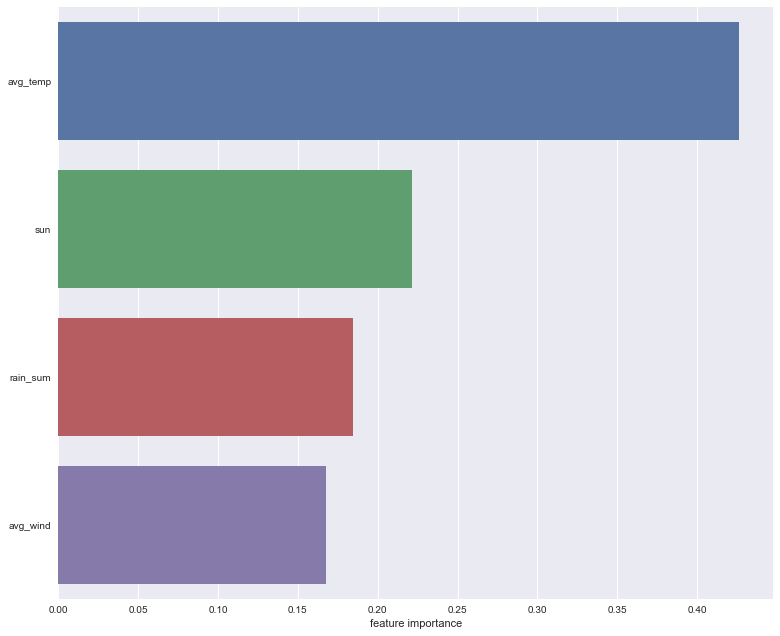

In [870]:
#plot
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=x_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [986]:
y_train

,consumption
index,
2000-02-01,-30346.0
2000-03-01,44758.0
2000-04-01,-7959.0
2000-05-01,-7416.0
2000-06-01,-61825.0
2000-07-01,63727.0
2000-08-01,-48657.0
2000-09-01,-28560.0
2000-10-01,53243.0


In [871]:
from statsmodels.tsa.api import VAR, DynamicVAR
var_data = pd.concat([x_train,y_train],axis=1)

In [872]:
model = VAR(var_data)

In [873]:
model.select_order(12)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         39.70        39.79    1.738e+17        39.73
1         37.97        38.50    3.080e+16        38.18
2         36.05        37.03    4.542e+15        36.45
3         35.45       36.87*    2.493e+15        36.03
4         35.21        37.08    1.975e+15       35.97*
5         35.14        37.45    1.837e+15        36.08
6         35.18        37.94    1.928e+15        36.30
7         35.13        38.34    1.859e+15        36.43
8         35.14        38.79    1.909e+15        36.62
9         35.17        39.27    2.002e+15        36.83
10        35.25        39.79    2.198e+15        37.09
11       34.98*        39.97   1.740e+15*        37.01
12        35.01        40.44    1.843e+15        37.21
* Minimum



/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


{'aic': 11, 'bic': 3, 'fpe': 11, 'hqic': 4}

In [874]:
#モデルはaic
var_result = model.fit(maxlags=12, ic='aic')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


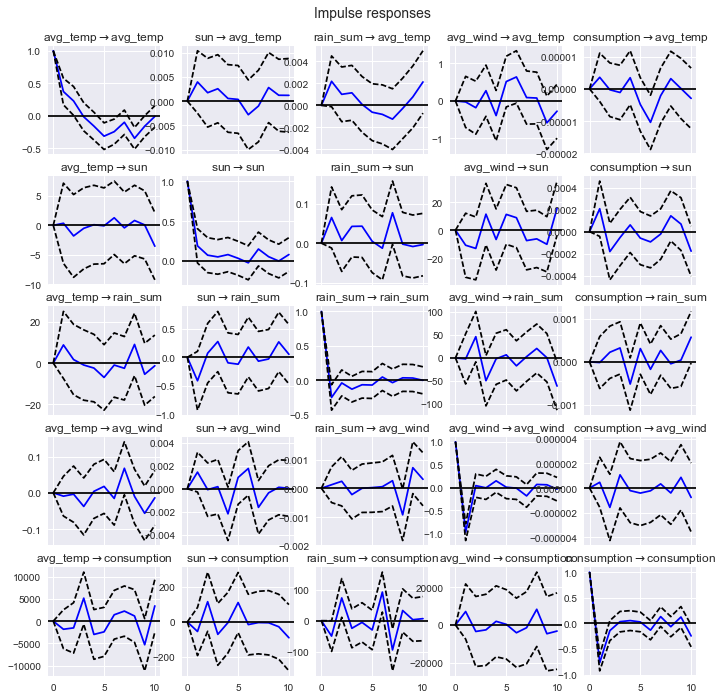

In [875]:
irf = var_result.irf(10)
irf.plot(orth=False)

In [949]:
var_result_aic.pvalues

,avg_temp,sun,rain_sum,avg_wind,consumption
const,0.002264,0.424996,0.619801,4.074113e-02,5.398237e-01
L1.avg_temp,0.000496,0.918491,0.290560,7.428916e-01,4.140779e-01
L1.sun,0.232167,0.087089,0.121289,1.057884e-01,4.374782e-01
L1.rain_sum,0.065577,0.101977,0.009408,6.978715e-01,5.114301e-02
L1.avg_wind,0.942049,0.356026,0.939852,1.314000e-18,3.410025e-01
L1.consumption,0.349330,0.107349,0.961669,6.541578e-01,4.500102e-16
L2.avg_temp,0.513591,0.549197,0.937928,7.447765e-01,4.828215e-01
L2.sun,0.845140,0.421980,0.952981,1.954229e-01,3.920536e-01
L2.rain_sum,0.588894,0.601047,0.344559,2.980271e-01,2.614437e-01
L2.avg_wind,0.708418,0.141076,0.284863,4.862205e-11,4.058480e-01


In [876]:
var_result_aic.test_causality('consumption', ['avg_temp','rain_sum','sun'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.397903         1.455309            0.071  (33, 620)
H_0: ['avg_temp', 'rain_sum', 'sun'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4553091470106816,
 'df': (33, 620),
 'pvalue': 0.07106709099462163,
 'signif': 0.05,
 'statistic': 1.397903486939458}

## ムー因果関係がないと出てしまっている（windは覗くのが一番いいpvalueが低い）
## 他のデータをつかっちゃおう！

In [877]:
#雪とか、日別最高気温月平均とか
new_data = pd.read_csv('data5.csv', index_col='year',parse_dates=True)

In [878]:
print (st.adfuller(new_data['daily_low_temp'].values.ravel()))
print (st.adfuller(new_data['daily_high_temp'].values.ravel()))
print (st.adfuller(new_data['snow'].values.ravel()))

(-2.637142116850712, 0.08556111667095184, 11, 192, {'1%': -3.4648754262570978, '5%': -2.876714157488788, '10%': -2.574858699001736}, 574.2828019006081)
(-3.693963407361943, 0.004198869899776495, 15, 188, {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}, 647.1928519822028)
(-14.530761247364511, 5.336287013911243e-27, 0, 203, {'1%': -3.462980134086401, '5%': -2.875885461947131, '10%': -2.5744164898444515}, 1008.7993722284343)


In [879]:
high_temp_org = new_data.loc[:,['daily_high_temp']].loc['2000-02-01':]
low_temp_diff = pd.DataFrame(new_data['daily_low_temp'].diff().dropna())
#high_temp_diff = pd.DataFrame(new_data['daily_high_temp'].diff().dropna())
#snow_diff = pd.DataFrame(new_data['snow'].diff().dropna())

# いえーい定常過程だね
# じゃあ、そのまま相関関係見ちゃお

In [880]:
new_diff_data = pd.concat([low_temp_diff,high_temp_org],axis=1)

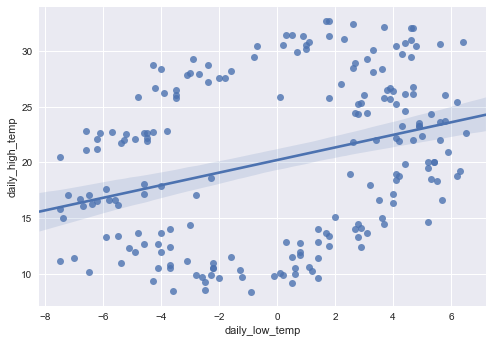

In [881]:
sns.regplot(x=low_temp_diff['daily_low_temp'] ,y=high_temp_org['daily_high_temp'])

# どっちかしかつかえないね。

In [909]:
var_data_2 = pd.concat([x_train,y_train,new_data],axis=1).loc[:'2015-12-01'].dropna()
var_data_3 = pd.concat([x_train,y_train,new_diff_data],axis=1).loc[:'2015-12-01'].dropna()

In [911]:
#model2は原系列のみ
model2 = VAR(var_data_2)
#model3は差分系列と原系列
model3 = VAR(var_data_3)

In [912]:
model3.select_order(12)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         39.39        39.51    1.278e+17        39.44
1         30.79        31.79    2.354e+13        31.19
2         29.74       31.61*    8.231e+12       30.49*
3         29.45        32.19    6.223e+12        30.56
4         29.04        32.66    4.180e+12        30.51
5         28.99        33.47   4.028e+12*        30.80
6         29.12        34.48    4.758e+12        31.30
7         29.09        35.32    4.777e+12        31.62
8         28.97        36.08    4.501e+12        31.86
9         29.10        37.08    5.491e+12        32.34
10        29.16        38.01    6.363e+12        32.75
11        28.89        38.61    5.456e+12        32.83
12       28.89*        39.48    6.273e+12        33.18
* Minimum



/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


{'aic': 12, 'bic': 2, 'fpe': 5, 'hqic': 2}

In [885]:
var_data_2.head()

,avg_temp,sun,rain_sum,avg_wind,consumption,snow,daily_high_temp,daily_low_temp
2000-02-01,5.6,198.9,3.0,0.2,-30346.0,0,9.9,1.7
2000-03-01,9.0,202.7,114.0,0.5,44758.0,0,13.7,4.8
2000-04-01,14.0,173.7,117.5,-0.3,-7959.0,0,18.5,10.1
2000-05-01,19.1,197.1,74.5,-0.4,-7416.0,0,23.7,15.9
2000-06-01,21.4,132.6,267.0,0.0,-61825.0,0,25.2,18.7


In [886]:
var_result_2 = model2.fit(maxlags=12, ic='aic')
var_result_3 = model3.fit(maxlags=12, ic='aic')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


In [887]:
var_result_2.test_causality('consumption', ['rain_sum','sun','daily_high_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.257179         1.434920            0.147  (36, 656)
H_0: ['rain_sum', 'sun', 'daily_high_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4349202284828888,
 'df': (36, 656),
 'pvalue': 0.14707678231532959,
 'signif': 0.05,
 'statistic': 1.2571790849080446}

In [888]:
var_result_2.test_causality('consumption', ['rain_sum','sun','daily_low_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.978289         1.434920            0.507  (36, 656)
H_0: ['rain_sum', 'sun', 'daily_low_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4349202284828888,
 'df': (36, 656),
 'pvalue': 0.5070940174748911,
 'signif': 0.05,
 'statistic': 0.9782893141999229}

In [889]:
var_result_2.test_causality('consumption', ['rain_sum','sun','avg_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.087719         1.434920            0.336  (36, 656)
H_0: ['rain_sum', 'sun', 'avg_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4349202284828888,
 'df': (36, 656),
 'pvalue': 0.33598933489870925,
 'signif': 0.05,
 'statistic': 1.0877193497752808}

In [890]:
var_result_3.test_causality('consumption', ['rain_sum','sun','daily_high_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.142642         1.434865            0.263  (36, 658)
H_0: ['rain_sum', 'sun', 'daily_high_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4348647824684353,
 'df': (36, 658),
 'pvalue': 0.2632696405237387,
 'signif': 0.05,
 'statistic': 1.1426419207038103}

In [891]:
var_result_3.test_causality('consumption', ['rain_sum','sun','daily_low_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.978267         1.434865            0.507  (36, 658)
H_0: ['rain_sum', 'sun', 'daily_low_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4348647824684353,
 'df': (36, 658),
 'pvalue': 0.5071263029945785,
 'signif': 0.05,
 'statistic': 0.9782672836552044}

In [892]:
var_result_3.test_causality('consumption', ['rain_sum','sun','avg_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.057155         1.434865            0.381  (36, 658)
H_0: ['rain_sum', 'sun', 'avg_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4348647824684353,
 'df': (36, 658),
 'pvalue': 0.3807570983329137,
 'signif': 0.05,
 'statistic': 1.0571550785284163}

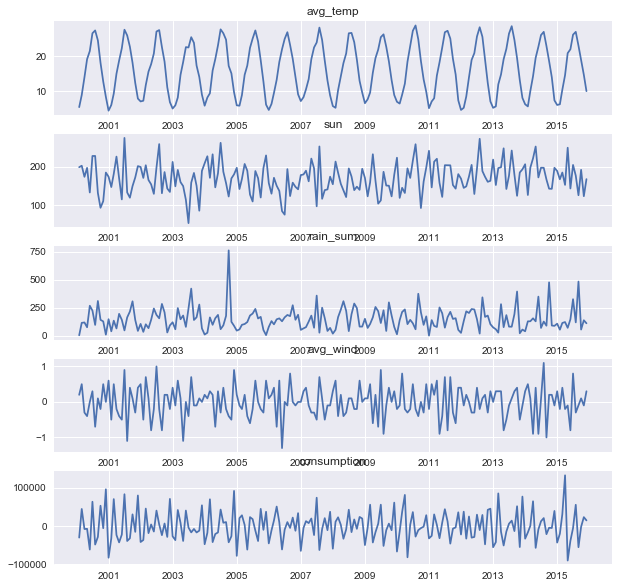

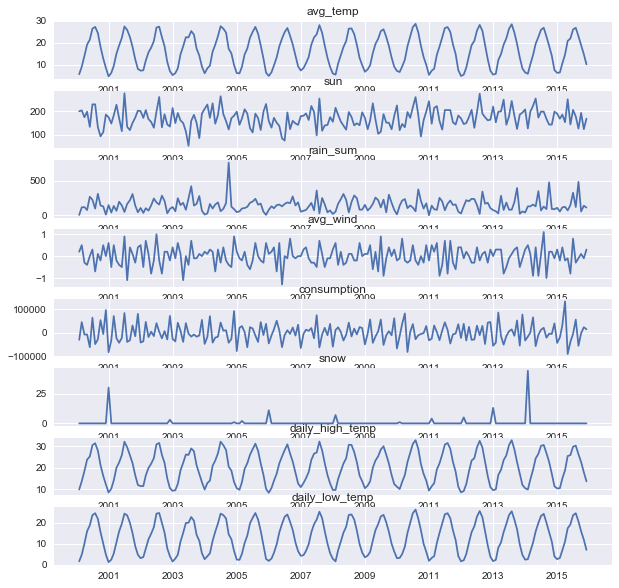

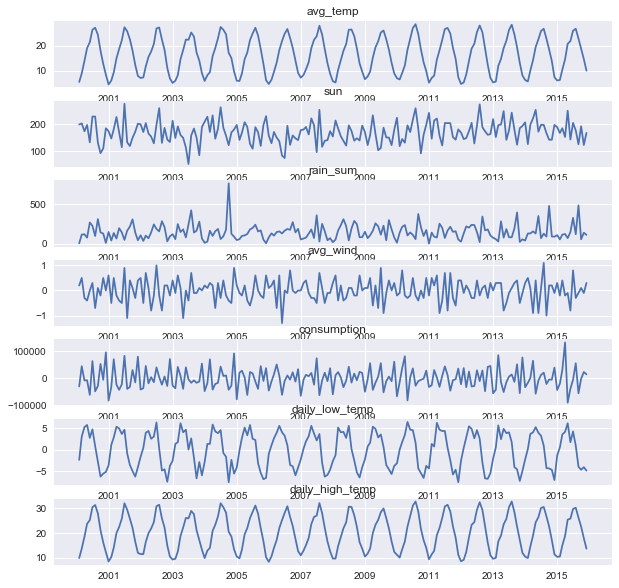

In [893]:
var_result.plot()
var_result_2.plot()
var_result_3.plot()

In [894]:
#差分に対してrandom forestすることでどれが目的変数に影響あるかを調べる
rf.fit(var_data_3.drop(['consumption'],axis=1) , y_train)
print('Training done using Random Forest')

Training done using Random Forest


/Users/Taishi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [895]:
var_data_3 = var_data_3.drop(['consumption'],axis=1)

/Users/Taishi/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


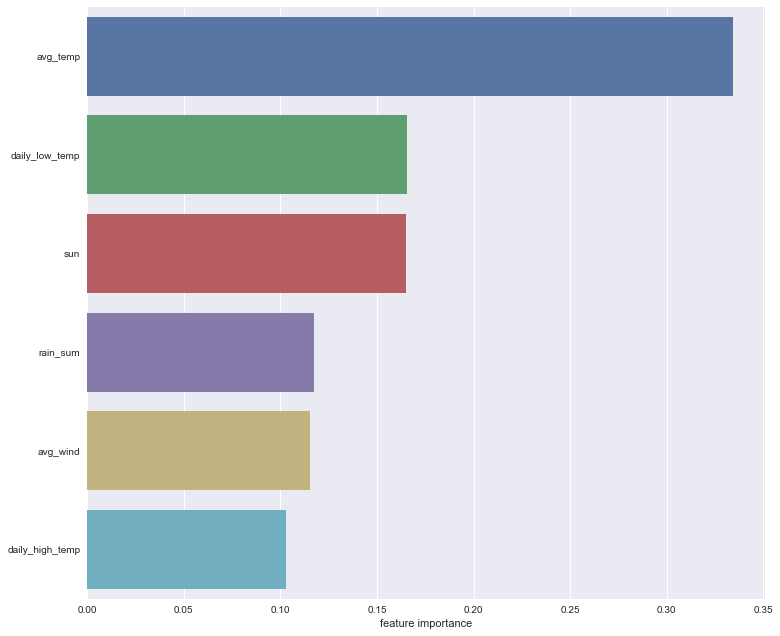

In [896]:
#plot
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=var_data_3.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

# Granger因果で、相関分析！！

In [897]:
granger_temp = st.grangercausalitytests(var_data_2.loc[:,['consumption','avg_temp']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3022  , p=0.5832  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.3071  , p=0.5795  , df=1
likelihood ratio test: chi2=0.3068  , p=0.5796  , df=1
parameter F test:         F=0.3022  , p=0.5832  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3403  , p=0.7120  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=0.6992  , p=0.7050  , df=2
likelihood ratio test: chi2=0.6979  , p=0.7054  , df=2
parameter F test:         F=0.3403  , p=0.7120  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3972  , p=0.2452  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=4.3537  , p=0.2257  , df=3
likelihood ratio test: chi2=4.3041  , p=0.2304  , df=3
parameter F test:         F=1.3972  , p=0.2452  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4322  , p=0.2252  

In [898]:
granger_rain = st.grangercausalitytests(var_data_2.loc[:,['consumption','rain_sum']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9183  , p=0.3392  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.9330  , p=0.3341  , df=1
likelihood ratio test: chi2=0.9307  , p=0.3347  , df=1
parameter F test:         F=0.9183  , p=0.3392  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9729  , p=0.0079  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=10.2160 , p=0.0060  , df=2
likelihood ratio test: chi2=9.9494  , p=0.0069  , df=2
parameter F test:         F=4.9729  , p=0.0079  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6192  , p=0.0523  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=8.1615  , p=0.0428  , df=3
likelihood ratio test: chi2=7.9893  , p=0.0462  , df=3
parameter F test:         F=2.6192  , p=0.0523  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7007  , p=0.1518  

# おおおおぉおおおおおおおおおおおおおお
雨量から、消費量は推定できそうじゃー！

In [899]:
granger = st.grangercausalitytests(var_data.loc[:,['consumption','wind']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1


/Users/Taishi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/Users/Taishi/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


LinAlgError: SVD did not converge

# 風量は論外くさい

In [900]:
granger = st.grangercausalitytests(var_data.loc[:,['consumption','sun']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.0341 , p=0.0002  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=14.2593 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7496 , p=0.0002  , df=1
parameter F test:         F=14.0341 , p=0.0002  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0598  , p=0.0188  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=8.3402  , p=0.0155  , df=2
likelihood ratio test: chi2=8.1614  , p=0.0169  , df=2
parameter F test:         F=4.0598  , p=0.0188  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5624  , p=0.2001  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=4.8684  , p=0.1817  , df=3
likelihood ratio test: chi2=4.8064  , p=0.1865  , df=3
parameter F test:         F=1.5624  , p=0.2001  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7387  , p=0.1435  

# Sunも良さそうだけども、どうなんだろ。雨増えたらsun減るとか。。？

In [901]:
granger_high = st.grangercausalitytests(var_data_2.loc[:,['consumption','daily_high_temp']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4446  , p=0.5057  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.4517  , p=0.5015  , df=1
likelihood ratio test: chi2=0.4512  , p=0.5018  , df=1
parameter F test:         F=0.4446  , p=0.5057  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3124  , p=0.7321  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=0.6417  , p=0.7255  , df=2
likelihood ratio test: chi2=0.6406  , p=0.7259  , df=2
parameter F test:         F=0.3124  , p=0.7321  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3810  , p=0.2501  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=4.3031  , p=0.2305  , df=3
likelihood ratio test: chi2=4.2546  , p=0.2353  , df=3
parameter F test:         F=1.3810  , p=0.2501  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5307  , p=0.1952  

In [902]:
# future_consumption = a * consumption(yt-1) + b *  high_temp + c * rain + d * sun

In [983]:
var_data_3['past_consumption'] = tar_data['消費支出'].shift(1,axis=0)

In [984]:
var_data_3

,avg_temp,sun,rain_sum,avg_wind,consumption,daily_low_temp,daily_high_temp,past_consumption
2000-03-01,9.0,202.7,114.0,0.5,44758.0,3.1,13.7,-30346.0
2000-04-01,14.0,173.7,117.5,-0.3,-7959.0,5.3,18.5,44758.0
2000-05-01,19.1,197.1,74.5,-0.4,-7416.0,5.8,23.7,-7959.0
2000-06-01,21.4,132.6,267.0,0.0,-61825.0,2.8,25.2,-7416.0
2000-07-01,26.4,228.2,223.5,0.3,63727.0,4.8,30.4,-61825.0
2000-08-01,27.2,228.3,95.5,-0.7,-48657.0,0.9,31.3,63727.0
2000-09-01,24.4,131.4,309.5,0.1,-28560.0,-2.7,27.9,-48657.0
2000-10-01,18.1,92.6,141.0,-0.2,53243.0,-6.2,21.2,-28560.0
2000-11-01,12.8,110.0,127.0,0.5,-5762.0,-5.5,16.2,53243.0
2000-12-01,8.5,184.8,8.5,0.0,96337.0,-5.1,12.3,-5762.0


In [975]:
var_data_3 = var_data_3.loc['2000-03-01':]

In [976]:
var_data_3

,avg_temp,sun,rain_sum,avg_wind,consumption,daily_low_temp,daily_high_temp,past_consumption
2000-03-01,9.0,202.7,114.0,0.5,44758.0,3.1,13.7,-7959.0
2000-04-01,14.0,173.7,117.5,-0.3,-7959.0,5.3,18.5,-7416.0
2000-05-01,19.1,197.1,74.5,-0.4,-7416.0,5.8,23.7,-61825.0
2000-06-01,21.4,132.6,267.0,0.0,-61825.0,2.8,25.2,63727.0
2000-07-01,26.4,228.2,223.5,0.3,63727.0,4.8,30.4,-48657.0
2000-08-01,27.2,228.3,95.5,-0.7,-48657.0,0.9,31.3,-28560.0
2000-09-01,24.4,131.4,309.5,0.1,-28560.0,-2.7,27.9,53243.0
2000-10-01,18.1,92.6,141.0,-0.2,53243.0,-6.2,21.2,-5762.0
2000-11-01,12.8,110.0,127.0,0.5,-5762.0,-5.5,16.2,96337.0
2000-12-01,8.5,184.8,8.5,0.0,96337.0,-5.1,12.3,-83227.0


In [959]:
model4 = VAR(var_data_3)

In [960]:
var_result_4 = model4.fit(maxlags=12, ic='aic')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


In [972]:
var_result_4.test_causality('consumption', ['avg_temp','rain_sum','sun','past_consumption'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         8.584814         1.945159            0.000  (8, 1368)
H_0: ['avg_temp', 'rain_sum', 'sun', 'past_consumption'] do not Granger-cause consumption
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 1.9451591859826192,
 'df': (8, 1368),
 'pvalue': 1.805227647063633e-11,
 'signif': 0.05,
 'statistic': 8.584814002873633}

In [928]:
lr_y = pd.DataFrame(var_data_3['consumption']).dropna().as_matrix()
lr_x = var_data_3.loc[:,['sun','rain_sum','avg_temp']].dropna()

In [930]:
tai = lr.fit(lr_y,lr_x)

/Users/Taishi/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [931]:
model_coef = pd.DataFrame(lr.coef_).T
model_coef.columns = ['sun','rain','daily_high_temp']

In [932]:
model_coef

,sun,rain,daily_high_temp
0,-0.000036,-0.000104,-0.000005


In [933]:
x_true_value = w_data.diff().dropna().loc['2016-01-01':]

In [934]:
x_true_value.head(1)

,avg_temp,sun,avg_wind,rain_sum
year,,,,


In [935]:
y_true_value.head(1)

NameError: name 'y_true_value' is not defined

In [ ]:
y_true_value = 